## Programming WF for ADCP DATA -- MV 2023
### © In_coast lab author: C. Hart, 2024-01-05

In [1]:
# Import necessary libraries
import easygui
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
sys.path.append(r'c:\users\s1495478\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

Index(['DateTime', 'Battery', 'Heading', 'Pitch', 'Roll', 'Pressure',
       'Temperature', 'AnalogIn1', 'AnalogIn2', 'Speed#1(0.30m)',
       'Dir#1(0.30m)', 'Speed#2(0.50m)', 'Dir#2(0.50m)', 'Speed#3(0.70m)',
       'Dir#3(0.70m)', 'Speed#4(0.90m)', 'Dir#4(0.90m)', 'Speed#5(1.10m)',
       'Dir#5(1.10m)', 'Speed#6(1.30m)', 'Dir#6(1.30m)', 'Speed#7(1.50m)',
       'Dir#7(1.50m)', 'Speed#8(1.70m)', 'Dir#8(1.70m)', 'Speed#9(1.90m)',
       'Dir#9(1.90m)', 'Speed#10(2.10m)', 'Dir#10(2.10m)', 'Speed#11(2.30m)',
       'Dir#11(2.30m)', 'Speed#12(2.50m)', 'Dir#12(2.50m)', 'Speed#13(2.70m)',
       'Dir#13(2.70m)', 'Speed#14(2.90m)', 'Dir#14(2.90m)', 'Speed#15(3.10m)',
       'Dir#15(3.10m)', 'Speed#16(3.30m)', 'Dir#16(3.30m)', 'Speed#17(3.50m)',
       'Dir#17(3.50m)', 'Speed#18(3.70m)', 'Dir#18(3.70m)', 'Speed#19(3.90m)',
       'Dir#19(3.90m)', 'Speed#20(4.10m)', 'Dir#20(4.10m)'],
      dtype='object')
5.534


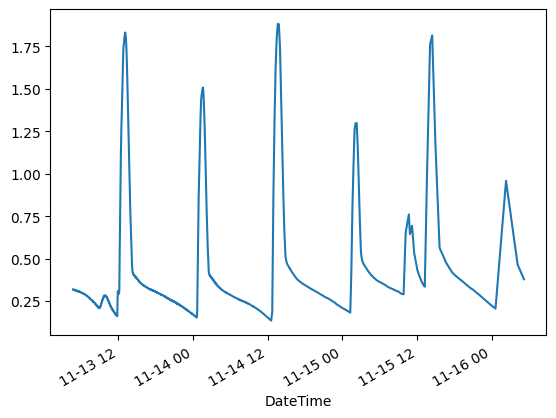

In [42]:
# read ADCP DATA and set index as DateTime
# file_path = r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_1_p.csv"
file_path = r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_2_p.csv"

GNSS_path = r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\TRURO_20231116_HYDRO.txt"
# GNSS_path = r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\TRURO_2023_HYDRO.txt"

gf = pd.read_csv(GNSS_path, delimiter=',')
gf = gf.set_index('PtID')

# df = df.drop(df.index)
df = pd.read_csv(file_path, quotechar='"', delimiter=';', skipinitialspace=True)
print(df.columns)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
df['Pressure'].plot()

print(gf['OHeight']['ADCP-NEW'])

C:\Users\S1495478\AppData\Local\Temp\ipykernel_15652\605938539.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pf['DateTime'] = pd.to_datetime(pf['Date'] + ' ' + pf['Time'])


Index(['Date', 'Time', 'Pressure'], dtype='object')


<Axes: xlabel='DateTime'>

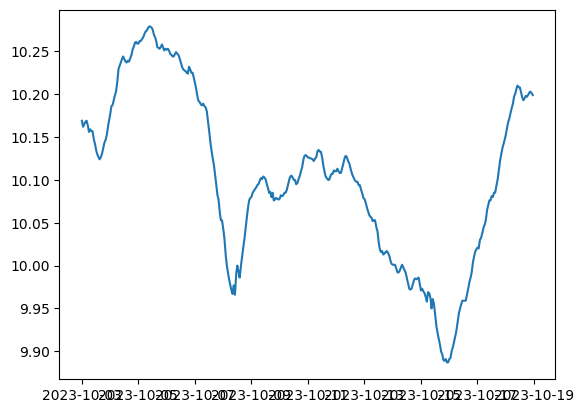

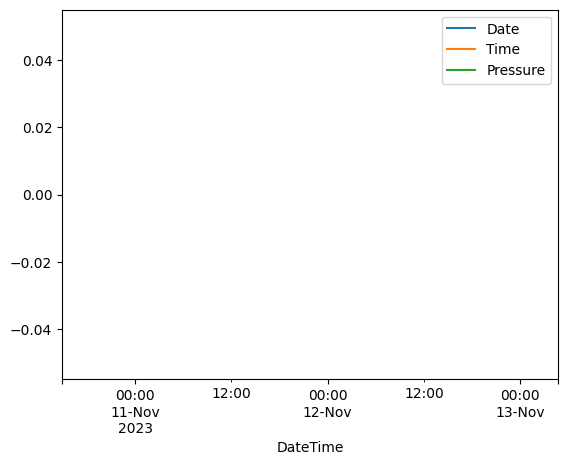

In [12]:
# read pressure data
# csv_file_path = r'C:\Users\S1495478\Documents\Weather Underground\ONS_pres_20231113.txt'
csv_file_path = r"C:\Users\S1495478\Documents\Weather Underground\MV_pres_20231003.txt"
pf = pd.read_csv(csv_file_path, delimiter='\t')
pf['DateTime'] = pd.to_datetime(pf['Date'] + ' ' + pf['Time'])
pf = pf.set_index('DateTime')
pf = pf.rename(columns={'pres (kPa)': 'Pressure'})
pf['Pressure'] = pf['Pressure'] / 10
pf = pf.resample('S').interpolate()
print(pf.columns)

# Interpolate pressure timeseries to fit the rsk
interpolated_pf = pf.reindex(df.index)
interpolated_pf['Pressure'] = interpolated_pf['Pressure'].interpolate(method='linear')

plt.plot(pf.index, pf['Pressure'])
interpolated_pf.plot()

# plt.plot(pf.index, pf['Pressure'])
# plt.plot(df.index, df['Pressure'])
# df['Pressure'].plot()
# plt.show()

# print(interpolated_pf['Pressure'])
# for i in range(len(interpolated_pf)):
#     print(interpolated_pf['Pressure'][i])

In [15]:
# Create a list with all the speed column names
speed_columns = []
dir_columns = []
initial = 0.1
it = 0.2

num=21

for i in range(1,num):
    speed_columns.append('Speed#' + str(i) + '(' + str(round(initial + it*(i),1)) + str(0) + 'm)')
print(speed_columns)
for i in range(1,num):
    dir_columns.append('Dir#' + str(i) + '(' + str(round(initial + it*(i),1)) + str(0) + 'm)')
print(dir_columns)

['Speed#1(0.30m)', 'Speed#2(0.50m)', 'Speed#3(0.70m)', 'Speed#4(0.90m)', 'Speed#5(1.10m)', 'Speed#6(1.30m)', 'Speed#7(1.50m)', 'Speed#8(1.70m)', 'Speed#9(1.90m)', 'Speed#10(2.10m)', 'Speed#11(2.30m)', 'Speed#12(2.50m)', 'Speed#13(2.70m)', 'Speed#14(2.90m)', 'Speed#15(3.10m)', 'Speed#16(3.30m)', 'Speed#17(3.50m)', 'Speed#18(3.70m)', 'Speed#19(3.90m)', 'Speed#20(4.10m)']
['Dir#1(0.30m)', 'Dir#2(0.50m)', 'Dir#3(0.70m)', 'Dir#4(0.90m)', 'Dir#5(1.10m)', 'Dir#6(1.30m)', 'Dir#7(1.50m)', 'Dir#8(1.70m)', 'Dir#9(1.90m)', 'Dir#10(2.10m)', 'Dir#11(2.30m)', 'Dir#12(2.50m)', 'Dir#13(2.70m)', 'Dir#14(2.90m)', 'Dir#15(3.10m)', 'Dir#16(3.30m)', 'Dir#17(3.50m)', 'Dir#18(3.70m)', 'Dir#19(3.90m)', 'Dir#20(4.10m)']


In [43]:
# Assuming df is your DataFrame
# file_path = r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_1_p.v3", r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_1_p.v1", r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_1_p.v2"
file_path = r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_2_p.v3", r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_2_p.v1", r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\tru2mh01_2_p.v2"

data_array = np.loadtxt(file_path[1])
data = np.loadtxt(file_path[1])

# Depth column for colormap
depth_columns = []
depths = []

for col in speed_columns:
    depth = col[8:-2]
    if depth.startswith('('): depth = depth[1:]
    depths.append(float(depth))
    depth_column = 'Depth' + str(col[5:-7])
    depth_columns.append(depth_column)
    df[depth_column] = depth

# for i in range(0, len(speed_columns)):
#     col = []
#     for j in range(len(df[speed_columns[i]])):
#         col.append(df[speed_columns[i]][j])   
#     col_df = pd.DataFrame(col, columns=['col'], index=df.index)
#     new_column = pd.DataFrame({
#         'data_column': col_df['col'],  # Example: Sum of existing columns
#     })
#     df = pd.concat([df, new_column], axis=1)

for i in range(0, len(speed_columns)):
    new_column = pd.DataFrame({
        'dir_column': df[dir_columns[i]],  # Example: Sum of existing columns
    })
    df = pd.concat([df, new_column], axis=1)
    
for i in range(0, len(speed_columns)):
    new_column = pd.DataFrame({
        'speed_column': df[speed_columns[i]],  # Example: Sum of existing columns
    })
    df = pd.concat([df, new_column], axis=1)

In [44]:
print(df.columns)
print(df['speed_column'].shape)
# print(data)

Index(['Battery', 'Heading', 'Pitch', 'Roll', 'Pressure', 'Temperature',
       'AnalogIn1', 'AnalogIn2', 'Speed#1(0.30m)', 'Dir#1(0.30m)',
       ...
       'speed_column', 'speed_column', 'speed_column', 'speed_column',
       'speed_column', 'speed_column', 'speed_column', 'speed_column',
       'speed_column', 'speed_column'],
      dtype='object', length=108)
(6158, 20)


In [45]:
# Declare dates for getting data from tides.gc
from datetime import datetime, timedelta

# Define start and end dates
start_date = datetime(2023, 11, 9)
end_date = datetime(2023, 11, 14)

# Create a list of dates in yyyy-mm-dd format
date_list = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range((end_date - start_date).days)]

# Print the list of dates
print(len(date_list))

# Create a list of timestamps by hour
hourly_timestamps = [(start_date + timedelta(days=1) + timedelta(hours=i)).strftime('%Y-%m-%d %H:%M:%S') for i in range(int((end_date - start_date).total_seconds() / 3600))]

# Print the list of hourly timestamps
print(len(hourly_timestamps)/24)

5
5.0


In [20]:
# Get/download tides.gc data 
import requests
from bs4 import BeautifulSoup

tide_predictions = []

for date in date_list:
    
    print(date)

    url = 'https://tides.gc.ca/en/stations/00270/' + date + '?tz=ADT&unit=m'

    # Fetch the HTML content
    response = requests.get(url)
    html_content = response.content

    # Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all <td> elements containing the numbers
    td_elements = soup.find_all('td')

    # Extract and print the numbers
    numbers = [td.get_text(strip=True) for td in td_elements if td.get_text(strip=True).replace('.', '', 1).isdigit()]

    init=77
    for i in range(init, init+24):
        tide_predictions.append(float(numbers[i]))
    
print(len(tide_predictions)/24)

2023-11-09
2023-11-10
2023-11-11
2023-11-12
2023-11-13
5.0


In [46]:
df_hourly = pd.DataFrame({'tide (m)': tide_predictions,
                         'date_index': pd.to_datetime(hourly_timestamps)
})

df_hourly = df_hourly.set_index('date_index')
df_hourly = df_hourly.sort_index()

print(type(tide_predictions))

df_minutely = df_hourly.resample('T').interpolate()

<class 'list'>


Index(['tide (m)'], dtype='object')


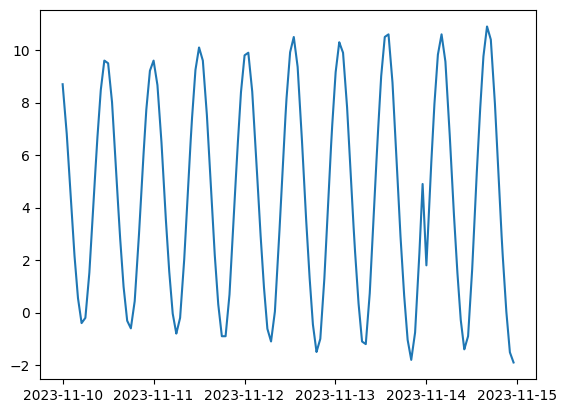

In [47]:
print(df_minutely.columns)
plt.plot(df_minutely['tide (m)']-3)


C:\Users\S1495478\AppData\Local\Temp\ipykernel_15652\4140838461.py:45: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  c1 = ax1.scatter(X, Y + gf['OHeight']['ADCP-NEW'], s=s, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')
C:\Users\S1495478\AppData\Local\Temp\ipykernel_15652\4140838461.py:106: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  c2 = ax2.scatter(X, Y + gf['OHeight']['ADCP-NEW'], s=s, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')


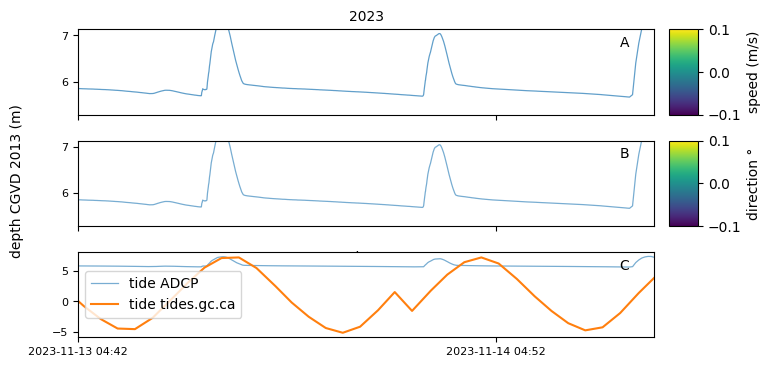

In [49]:
import numpy as np
import matplotlib.gridspec as gridspec

# Specify the file path
file_path = r"C:\Users\S1495478\Documents\ADCP\MV_20231004\MV202301_p.v1", r"C:\Users\S1495478\Documents\ADCP\MV_20231004\MV202301_p.v1", r"C:\Users\S1495478\Documents\ADCP\MV_20231004\MV202301_p.v2"

xlim = 8000
s=100

# data_array = np.loadtxt(file_path[1])
direction = df['dir_column'].to_numpy()
speed = df['speed_column'].to_numpy()

fig= plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.05], wspace=0.05, hspace=0.3)

speed = np.transpose(speed)
direction = np.transpose(direction)
# data_array = np.transpose(data_array)

# print(len(data_array[0]), len(speed_columns[0]), len(dir_columns[0]))
# print(len(data_array), len(speed_columns), len(dir_columns))

# Set a threshold for excluding values
threshold = -8
mask = np.array(speed) < -0.5

# Create a masked array to exclude values below the threshold
# masked_array = np.ma.masked_array(data_array, mask)
# masked_array = np.ma.masked_array(direction, mask)
masked_array = np.ma.masked_array(speed, mask)

# Print the resulting array
# Assuming x and y axes correspond to indices
x_axis = df.index
y_axis = depths

# Create a meshgrid from x and y axes
X, Y = np.meshgrid(x_axis, y_axis)

# Plot the filled contours
ax1 = plt.subplot(gs[0, 0])
cax1 = plt.subplot(gs[0, 1])

c1 = ax1.scatter(X, Y + gf['OHeight']['ADCP-NEW'], s=s, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')
# plt.contourf(X, Y, masked_array[:][0:len(df.index)], cmap='viridis')

num_ticks = 4

date_num = mdates.date2num(x_axis) # Convert datetime objects to numerical values
tick_positions = np.linspace(date_num.min(), date_num.max(), num=num_ticks) # Compute the tick positions
tick_dates = mdates.num2date(tick_positions) # Convert numerical values back to datetime objects

ax1.set_xticks(ticks=tick_dates)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_title('2023', fontsize=10)

# Add color bar for reference
# ax1[1].set_colorbar(label = 'speed (m/s)')
fig.colorbar(c1, cax=cax1, label = 'speed (m/s)')

# fig.colorbar(c1, ax=cax1, label = 'speed (m/s)')
# plt.colorbar(label = 'direction \u00B0')

# Label the axes
# ax1[1].xlabel('time')
# ax1[0].set_ylabel('depth (m)')

ax1.plot(df['Pressure'] + gf['OHeight']['ADCP-NEW'], label='ADCP water level', linewidth=0.9, alpha=0.7)
# plt.plot(pf.index, pf['Pressure'], linewidth=0.9, alpha=0.6, color='black')
# pf['Pressure'].plot()

# Set x-axis and y-axis limits
ax1.set_ylim(-0.25 + gf['OHeight']['ADCP-NEW'], 1.6 + gf['OHeight']['ADCP-NEW']) #y_axis[4])  # Adjust as needed
ax1.set_xlim(x_axis[0], x_axis[int(xlim)])  # Adjust as needed
# ax1[0].xticks(rotation=-25)

for label in ax1.get_xticklabels():
    label.set_alpha(0)
    
Letters = 'A', 'B'
ax1.text(0.94, 0.92, Letters[0], 
            transform=ax1.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0))

########################################## SECOND WINDOW ##############

# Create a masked array to exclude values below the threshold
# masked_array = np.ma.masked_array(data_array, mask)
# masked_array = np.ma.masked_array(direction, mask)
masked_array = np.ma.masked_array(direction, mask)

# Print the resulting array
# Assuming x and y axes correspond to indices
x_axis = df.index
y_axis = depths

# Create a meshgrid from x and y axes
X, Y = np.meshgrid(x_axis, y_axis)

# Plot the filled contours
ax2 = plt.subplot(gs[1, 0])
cax2 = plt.subplot(gs[1, 1])

c2 = ax2.scatter(X, Y + gf['OHeight']['ADCP-NEW'], s=s, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')
# plt.contourf(X, Y, masked_array[:][0:len(df.index)], cmap='viridis')

date_num = mdates.date2num(x_axis) # Convert datetime objects to numerical values
tick_positions = np.linspace(date_num.min(), date_num.max(), num=num_ticks) # Compute the tick positions
tick_dates = mdates.num2date(tick_positions) # Convert numerical values back to datetime objects

ax2.set_xticks(ticks=tick_dates)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax2.tick_params(axis='both', which='major', labelsize=8)

# Add color bar for reference
# ax1[1].set_colorbar(label = 'speed (m/s)')

fig.colorbar(c2, cax=cax2, label = 'direction \u00B0')
# plt.colorbar(label = 'direction \u00B0')

# Label the axes
ax2.set_xlabel('time')
# ax1[1].set_ylabel('depth (m)')

fig.text(0.04, 0.5, 'depth CGVD 2013 (m)', va='center', rotation='vertical')


ax2.plot(df['Pressure'] + gf['OHeight']['ADCP-NEW'], label='water level', linewidth=0.9, alpha=0.6)
# plt.plot(pf.index, pf['Pressure'], linewidth=0.9, alpha=0.6, color='black')
# pf['Pressure'].plot()

# Set x-axis and y-axis limits
ax2.set_ylim(-0.25 + gf['OHeight']['ADCP-NEW'], 1.6 + gf['OHeight']['ADCP-NEW']) #y_axis[4])  # Adjust as needed
ax2.set_xlim(x_axis[0], x_axis[int(xlim)])  # Adjust as needed
# ax1[0].xticks(rotation=-25)

Letters = 'A', 'B'
ax2.text(0.94, 0.92, Letters[1], 
            transform=ax2.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0))

for label in ax2.get_xticklabels():
    label.set_alpha(0)

#####################################################################################################
        
ax3 = plt.subplot(gs[2, 0])
cax3 = plt.subplot(gs[2, 1])

ax3.plot(df['Pressure'] + gf['OHeight']['ADCP-NEW'], label='tide ADCP', linewidth=0.9, alpha=0.6)
c3 = ax3.plot(df_minutely['tide (m)'] - 6.35, label='tide tides.gc.ca')
ax3.set_xlim(x_axis[0], x_axis[int(xlim)])  # Adjust as needed

Letters = 'A', 'B', 'C'
ax3.text(0.94, 0.92, Letters[2], 
            transform=ax3.transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0))

date_num = mdates.date2num(x_axis) # Convert datetime objects to numerical values
tick_positions = np.linspace(date_num.min(), date_num.max(), num=num_ticks) # Compute the tick positions
tick_dates = mdates.num2date(tick_positions) # Convert numerical values back to datetime objects

ax3.set_xticks(ticks=tick_dates)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_xlim(x_axis[0], x_axis[int(xlim)])  # Adjust as needed

ax3.legend()
# fig.colorbar(c2, ax=ax1[2], label = 'direction \u00B0', alpha=0.5)

# Hide the unused space in the grid spec (where the colorbar would be)
plt.subplot(gs[2, 1]).set_visible(False)


plt.savefig(r'C:\Users\S1495478\Documents\ADCP\Truro_nov23\\' + str(GNSS_path[48:61]) + '_1.png', dpi=300)  # Save the plot as a PNG file with 300 DPI

# # Show the plot
plt.show()

In [169]:
print(Y.shape, masked_array.shape)
print(speed)

valid_values = speed[speed != -9]
value_range = valid_values.max() - valid_values.min()

print(valid_values.max(), valid_values.min(), value_range)

(20, 1600) (20, 1600)
[[-9.    -9.    -9.    ...  0.517  0.521  0.535]
 [-9.    -9.    -9.    ... -9.    -9.    -9.   ]
 [-9.    -9.    -9.    ... -9.    -9.    -9.   ]
 ...
 [-9.    -9.    -9.    ... -9.    -9.    -9.   ]
 [-9.    -9.    -9.    ... -9.    -9.    -9.   ]
 [-9.    -9.    -9.    ... -9.    -9.    -9.   ]]
0.68 0.001 0.679


10.1316128125


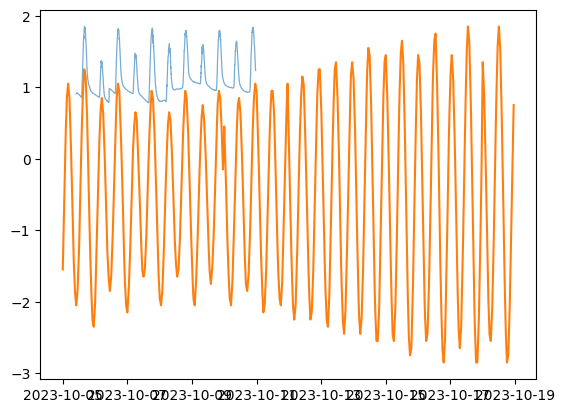

In [121]:
plt.plot(df['Pressure'] + gf['OHeight']['adcpsen'], label='ADCP water level', linewidth=0.9, alpha=0.6)

df = df[0:xlim+1]

# plt.plot(pf.index, pf['Pressure'], linewidth=0.9, alpha=0.6, color='black')
# pf['Pressure'].plot()

# # Set x-axis and y-axis limits
# ax1[0].set_ylim(0 + gf['OHeight']['adcpsen'], 1.3 + gf['OHeight']['adcpsen']) #y_axis[4])  # Adjust as needed
# ax1[0].set_xlim(x_axis[0], x_axis[int(xlim)])  # Adjust as needed
# # ax1[0].xticks(rotation=-25)

# for label in ax1[0].get_xticklabels():
#     label.set_alpha(0)
    
plt.plot(df_minutely['tide (m)'] - 3.55)

# interpolated_pf.plot()

interpolated_pf_min = interpolated_pf.resample('T').interpolate()
interpolated_pf_min = pf.reindex(df.index)

# for i in range(len(df['Pressure'])):
#     df['CorrPressure'][i] = df['Pressure'][i] - (interpolated_pf_min['Pressure'][i] - np.mean(interpolated_pf_min['Pressure']))/1
# plt.plot(df['CorrPressure']- gf['OHeight']['adcpsen'])
# interpolated_pf_min['Pressure'].plot()

# plt.plot(interpolated_pf_min['Pressure'])

# print(interpolated_pf)
print(np.mean(interpolated_pf_min['Pressure']))
# print(df_minutely['tide (m)'])

plt.show()